In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ma
import numpy.linalg as npl
import os
from scipy.misc import imresize
from sklearn.neighbors import KNeighborsClassifier as Knc
from keras import models
from keras import layers
import skimage.transform as skt
from sklearn.metrics.pairwise import cosine_similarity
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def contenu_dossier(path_dossier):
    
    path = path_dossier

    liste_noms = os.listdir(path_dossier)
    liste_chemins = []
    for name in liste_noms:
        if name[-4] != '.':
            liste_chemins2 = contenu_dossier(path_dossier+'/'+name)
            liste_chemins += liste_chemins2
        if name[-4:] == '.jpg':
            liste_chemins += [path_dossier+"/"+name]
        else:
            pass
        
    return liste_chemins
    

In [3]:
model = VGG16(include_top=False, weights='imagenet')

In [4]:
def compute_features(chemins):
    n = len(chemins)
    features = np.zeros((n,25088))
    
    for i in range(n):
        image = np.expand_dims(preprocess_input(skt.resize(plt.imread(chemins[i]),(224,224,3), mode = 'reflect', preserve_range = True)),axis=0)
        features[i,:] = model.predict(image).ravel()
    return features

In [5]:
def trouve_voisins(data, k, distance = "euclidean"):
    n = len(data)
    cible = np.zeros(n)
    data_knn = Knc(k, metric=distance)
    data_knn.fit(data, cible)
    return data_knn.kneighbors(data[-1].reshape(1, -1))

In [6]:
#fonction utile si on utilise la fonction knn
def affichage_voisins(data, k, voisins):
   # Affichage en gros de l'image principale
    plt.figure()
    plt.imshow(plt.imread(data[0]))
    plt.title("distance : " + str(voisins[0][0][0]))
    plt.show()
    
    # Affichage des autres au-dessous
    lines = k//4
    
    
    fig = plt.figure(figsize = (15,15))
    
    for i in range (1, k-1):
        fig.add_subplot(lines+1, 4, i)
        plt.imshow(plt.imread(data[voisins[1][0][i+1]]))
        plt.title("distance : " + str(voisins[0][0][i+1]))
    

    plt.tight_layout()
    plt.show() 
    

In [7]:
def cosine_voisins(data, k):
    distance_totale = cosine_similarity(data, data)
    voisins = np.argsort(-distance_totale[-1,:])[:k+2]
    distance = distance_totale[-1, voisins]
    return distance, voisins

In [250]:
def affichage_cosine(k, indice, autre, distance, voisins, chemins, nom):
   # Affichage en gros de l'image principale
    plt.figure()
    plt.imshow(plt.imread(chemins[0]))
    plt.title("similarité : " + str(distance[0]))
    plt.show()
    
    # Affichage des autres au-dessous
    lines = k//4
    
    
    fig = plt.figure(figsize = (15,15))
    
    for i in range (1, k):
        fig.add_subplot(lines+1, 4, i)
        if (voisins[i+1] <= indice and not autre) or (autre and nom=='' and voisins[i+1] <= indice):
            plt.imshow(plt.imread(chemins[voisins[i+1]+1]))
        else :
            plt.imshow(plt.imread(chemins[voisins[i+1]]))
        plt.title("similarité : " + str(distance[i+1]))
    

    plt.tight_layout()
    plt.show() 
    

In [9]:
#GENERATION DE TOUS LES CHEMINS
l_ring = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/ring")
l_bracelet = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/bracelet")
l_necklace = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/necklace")
l_earring = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/earring")

In [10]:
features_ring = compute_features(l_ring)
features_bracelet = compute_features(l_bracelet)
features_necklace = compute_features(l_necklace)
features_earring = compute_features(l_earring)

In [ ]:
def recup(indice, autre, nom=''):
    

In [198]:
def recuperation_features(indice, autre, nom=""):
    
    #concatenation des listes 
    if not autre :       
        if nom == 'ring' :
            data = list.copy(l_ring)
            B = data[indice]
            del data[indice]
            data = data[::-1]
            data += [B]
            features = np.concatenate((features_ring, features_ring[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
            
        elif nom == 'bracelet' :
            data = list.copy(l_bracelet)
            del data[indice]
            data = data[::-1]
            data += [l_bracelet[indice]]
            features = np.concatenate((features_bracelet, features_bracelet[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
            
        elif nom == 'necklace' : 
            data = list.copy(l_necklace)
            del data[indice]
            data = data[::-1]
            data += [l_necklace[indice]]
            features = np.concatenate((features_necklace, features_necklace[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
            
        elif nom == 'earring' :
            data = list.copy(l_earring)
            del data[indice]
            data = data[::-1]
            data += [l_earring[indice]]
            # data = [l_earring[indice]] + data
            features = np.concatenate((features_earring, features_earring[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
            
        else :
            data = l_ring + l_earring  + l_bracelet + l_necklace
            B = data[indice]
            del data[indice]
            data =  data[::-1]
            data += [B]
            features = np.concatenate((features_ring, features_earring, features_bracelet, features_necklace), axis = 0)
            features = np.concatenate((features, features[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
    
        
    else :
        if nom == 'ring' :
            data = l_earring + l_bracelet + l_necklace
            B = l_ring[indice]
            data = data[::-1]
            data += [B]
            features = np.concatenate((features_earring, features_bracelet, features_necklace), axis = 0)
            features = np.concatenate((features, features_ring[indice,:].reshape(1,-1)), axis = 0)
            
        elif nom == 'bracelet' :
            data = l_ring + l_earring + l_necklace
            B = l_bracelet[indice]
            data = data[::-1]
            data += [B]
            features = np.concatenate((features_ring, features_earring, features_necklace), axis = 0)
            features = np.concatenate((features, features_bracelet[indice,:].reshape(1,-1)), axis = 0)
            
        elif nom == 'necklace' : 
            data = l_ring + l_earring + l_bracelet
            data = data[::-1]
            data += [l_necklace[indice]]
            features = np.concatenate((features_ring, features_earring, features_bracelet), axis = 0)
            features = np.concatenate((features, features_necklace[indice,:].reshape(1,-1)), axis = 0)
            
        elif nom == 'earring' :
            data = l_ring + l_bracelet + l_necklace
            data = data[::-1]
            data += [l_earring[indice]]
            features = np.concatenate((features_ring, features_bracelet, features_necklace), axis = 0)
            features = np.concatenate((features, features_earring[indice,:].reshape(1,-1)), axis = 0)
            
        else :
            data = l_ring + l_earring + l_bracelet + l_necklace 
            B = data[indice]
            del data[indice]
            data = data[::-1]
            data += [B]
            features = np.concatenate((features_ring, features_earring, features_bracelet, features_necklace), axis = 0)
            features = np.concatenate((features, features[indice,:].reshape(1,-1)), axis = 0)
            np.delete(features, (indice), axis = 0)
    
    return data[::-1], features

In [337]:
#--------IMPORTANT-------------
indice = 5
k = 15
autre = True
nom="bracelet"
#--------IMPORTANT-------------

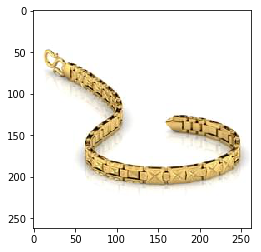

In [338]:
plt.imshow(plt.imread(l_bracelet[indice]))

In [339]:
#--------IMPORTANT-------------
l_chemins, features = recuperation_features(indice, autre, nom)
#--------IMPORTANT-------------

In [340]:
#--------IMPORTANT-------------
distance, voisins = cosine_voisins(features, k)
#--------IMPORTANT-------------

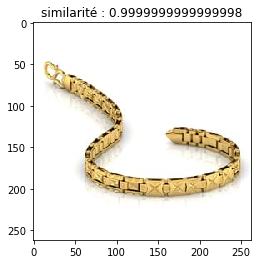

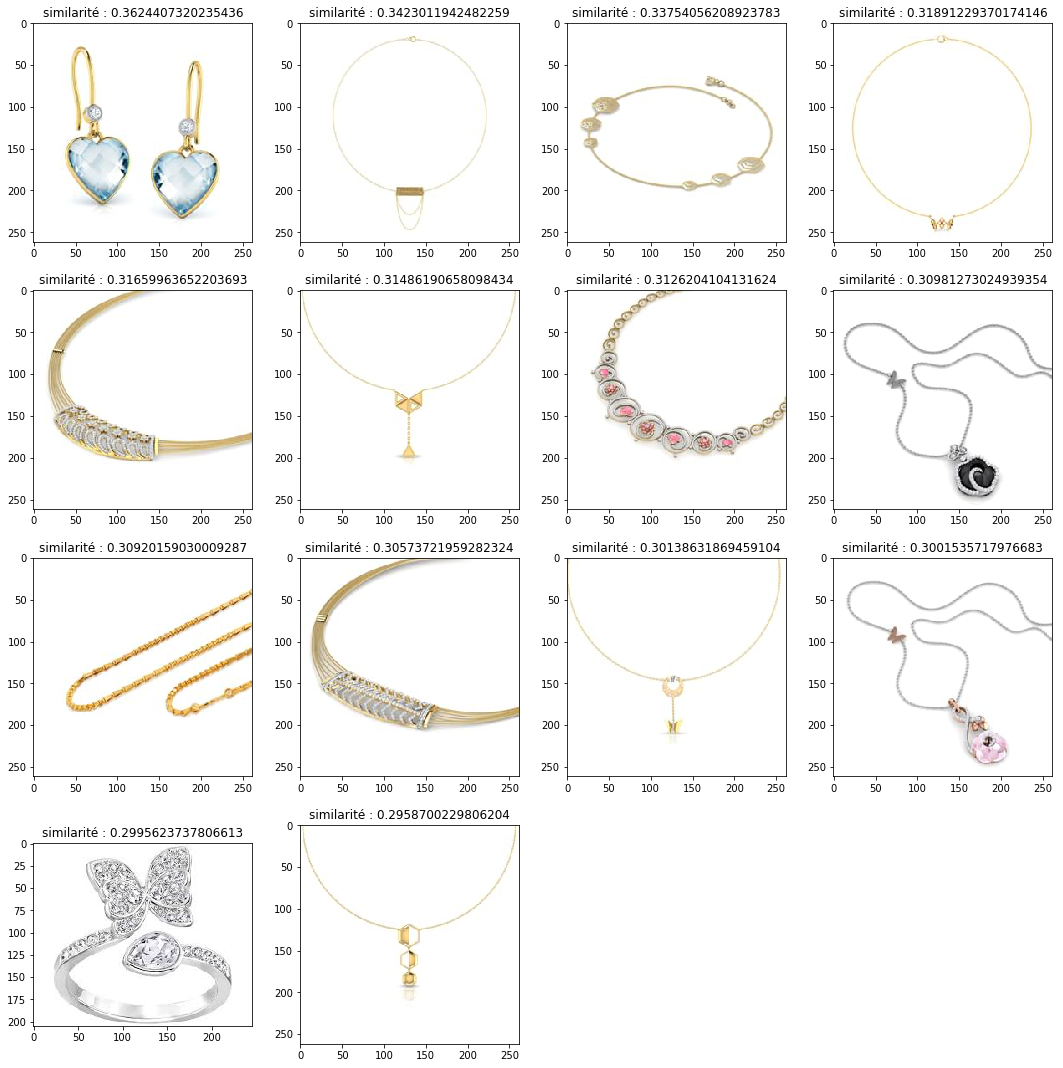

In [341]:
#--------IMPORTANT-------------
affichage_cosine(k, indice, autre, distance, voisins, l_chemins, nom)
#--------IMPORTANT-------------

In [311]:
#--------IMPORTANT-------------
voisins = trouve_voisins(features, k)
print(voisins)
#--------IMPORTANT-------------

(array([[   0.        , 1276.62551357, 1302.48404092, 1306.03378129,
        1311.49524126, 1319.33419709, 1319.65680287, 1321.53623024,
        1324.55411628, 1326.51940361, 1339.47916776, 1348.81397689,
        1349.75108015, 1350.89235558, 1351.20886629]]), array([[961, 769, 640, 955, 828, 710, 681,  77, 765, 684, 872, 696, 942,
        821, 895]]))


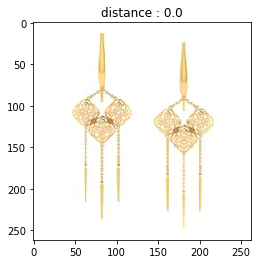

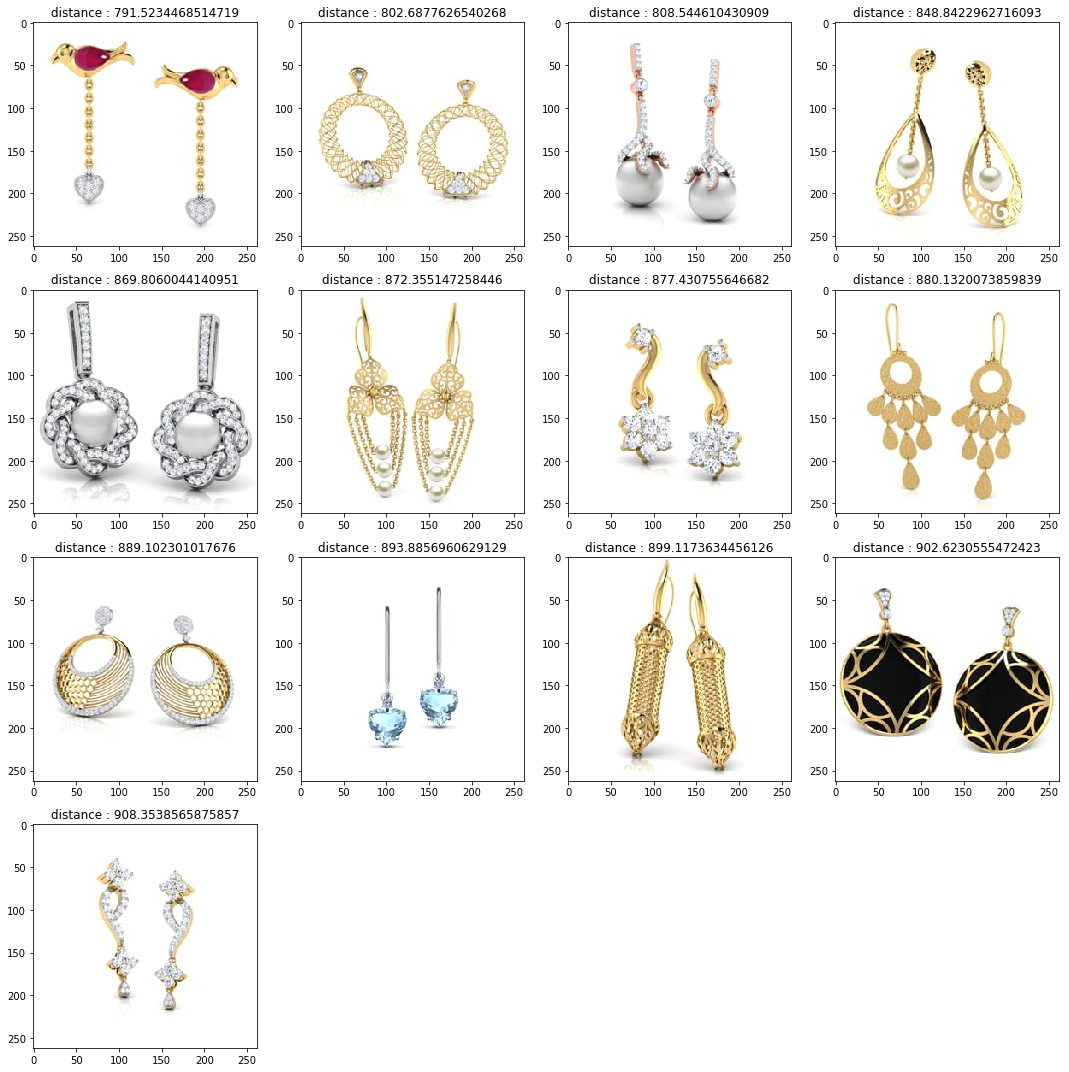

In [129]:
#--------IMPORTANT-------------
affichage_voisins(l_chemins, k, voisins)
#--------IMPORTANT-------------

In [45]:
tsne = TSNE(n_components=2, perplexity=10)
pca = PCA(50)

In [46]:
pca_features = pca.fit_transform(features)
tsne_points = tsne.fit_transform(pca_features)

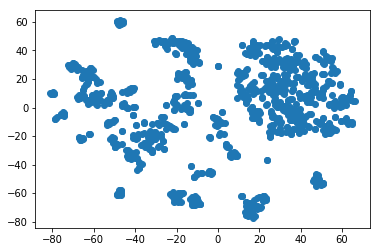

In [47]:
plt.scatter(tsne_points[:,0],tsne_points[:,1])

In [48]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.misc import imread, imresize

def imscatter(x, y, paths, ax=None, zoom=1, linewidth=0):
    if ax is None:
        plt.figure(figsize=(40,40))
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, p in zip(x, y, paths):
        try:
            im = imread(p)
        except:
            print(p)
            continue
        im = imresize(im,(80,80))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth));
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


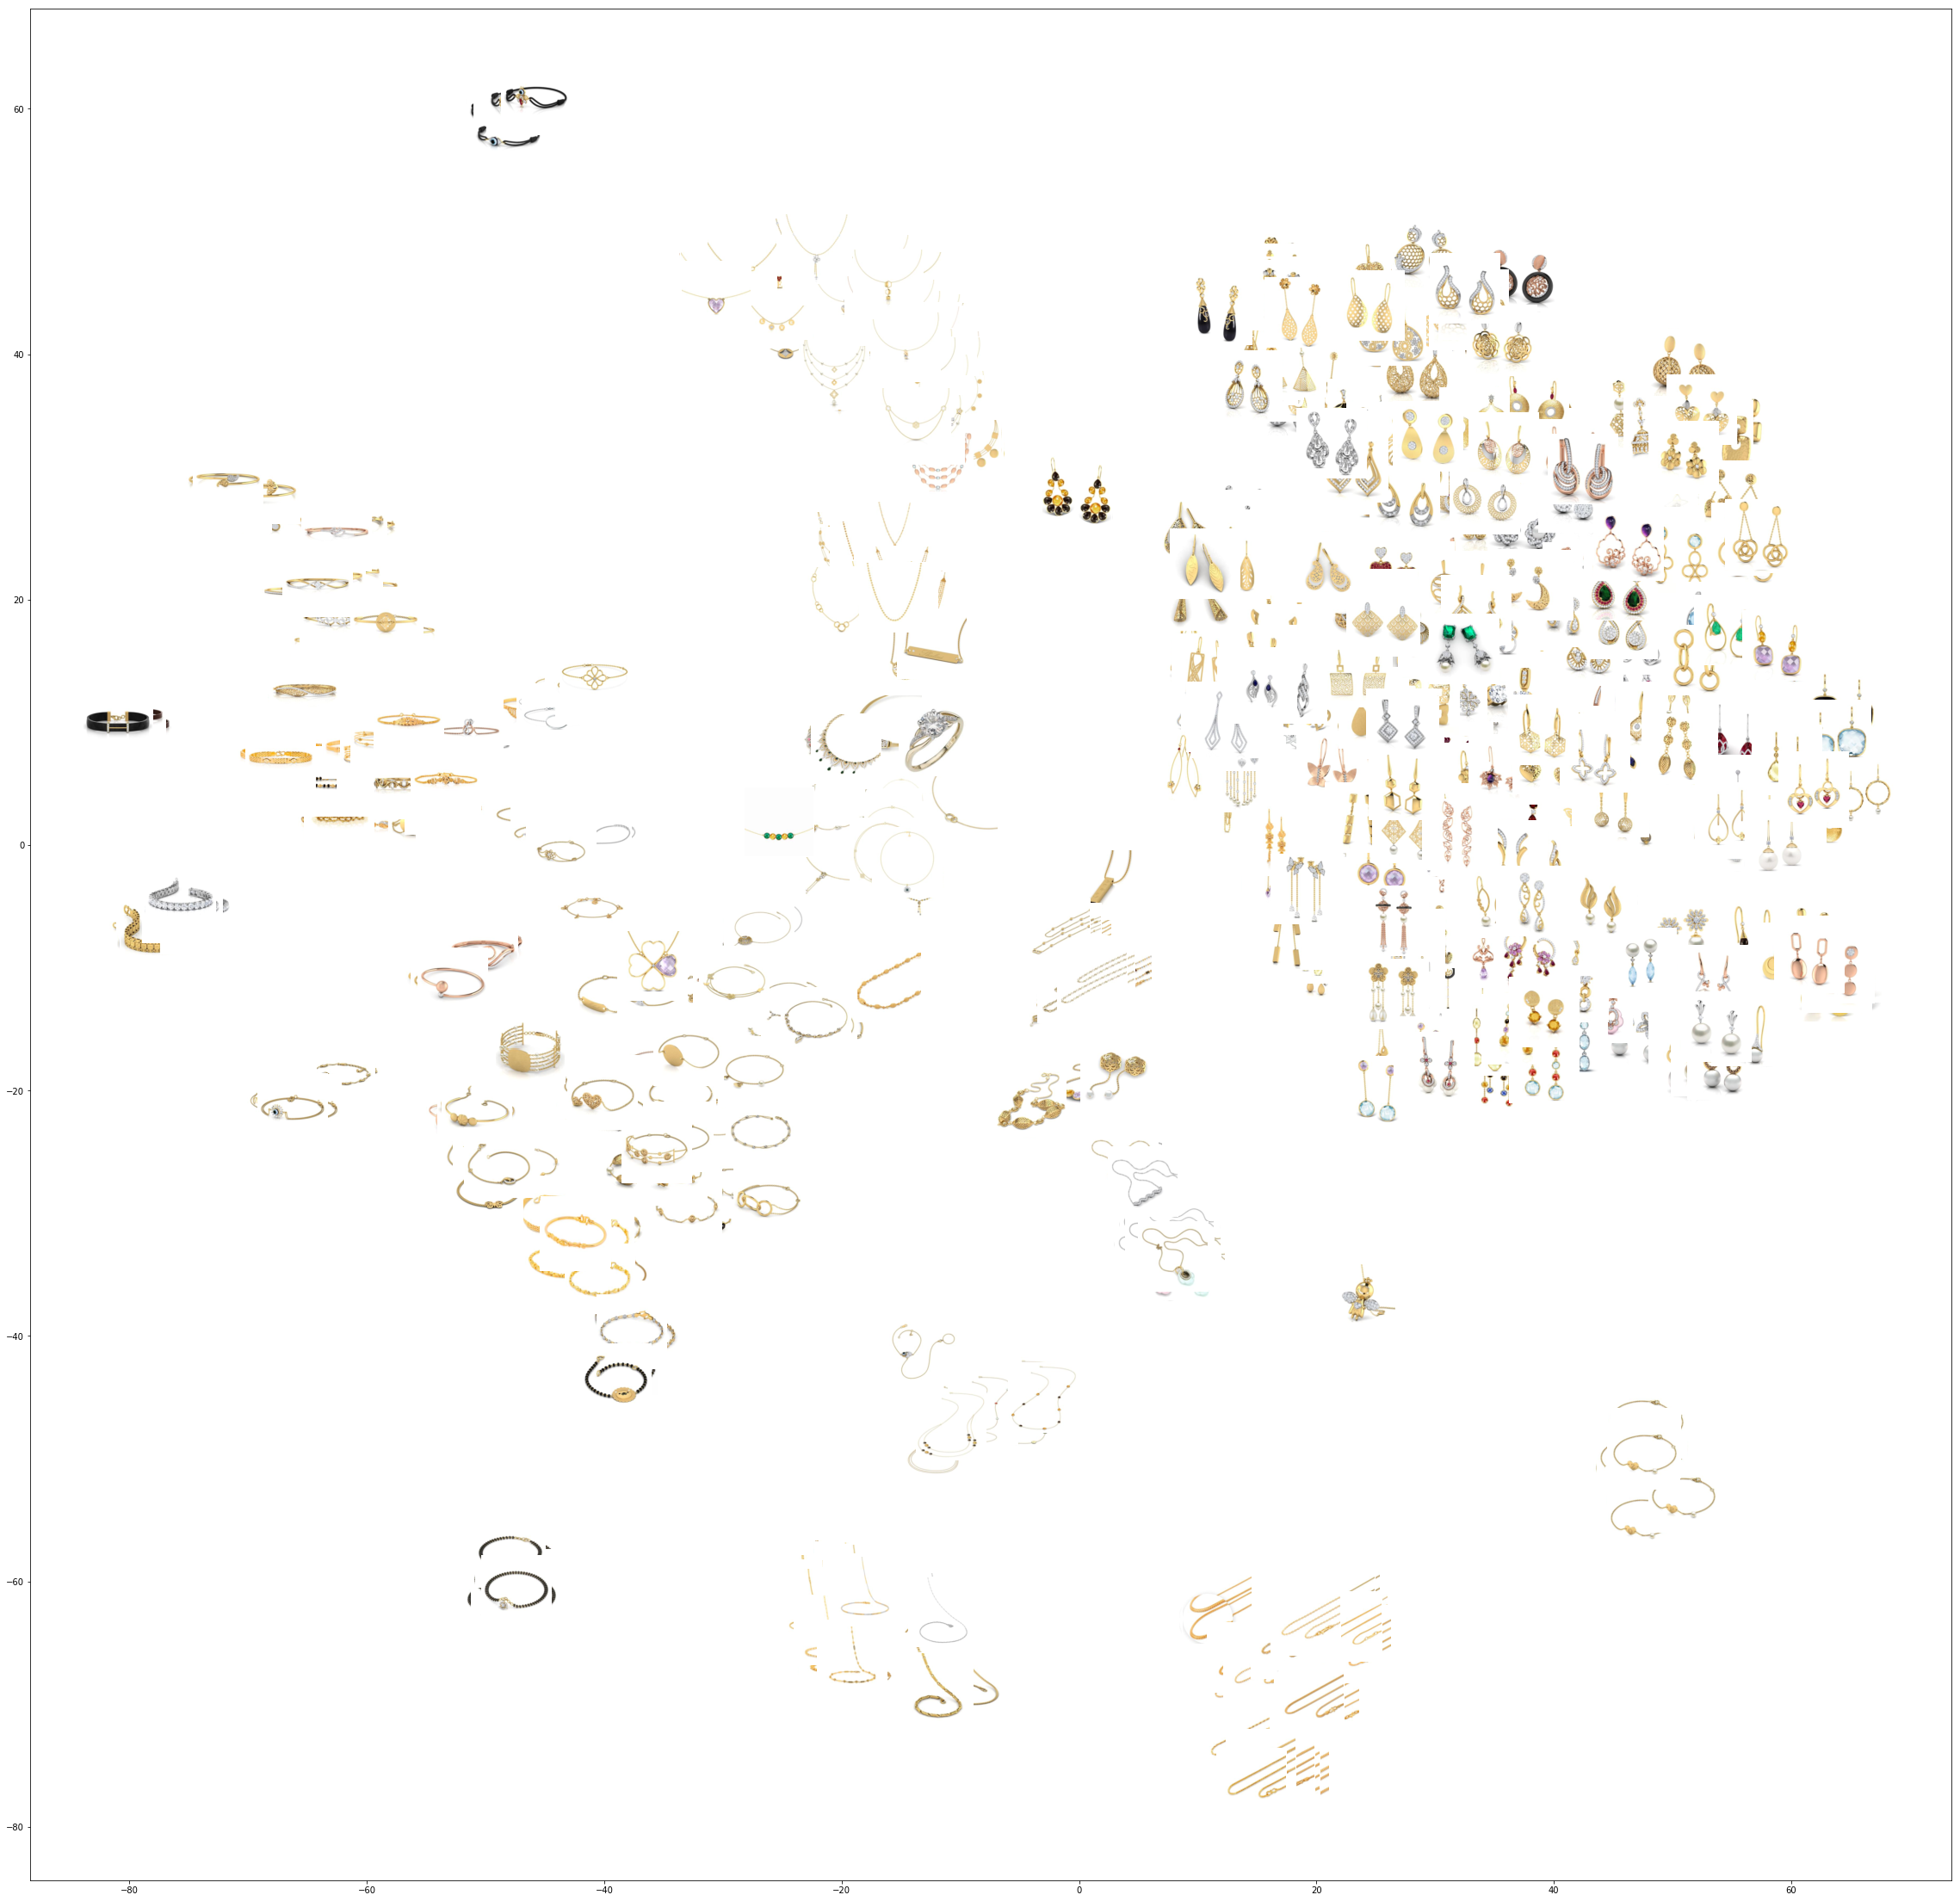

In [55]:
imscatter(tsne_points[:,0],tsne_points[:,1], l_chemins, ax=None, zoom=1, linewidth=0)
plt.show()